In [1]:
# Cell 1: Imports
from fibermodes import FiberFactory, Simulator
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Cell 2: Fiber setup
factory = FiberFactory()
factory.addLayer(name="core", radius=[25e-6], index=1.5)
factory.addLayer(name="cladding", index=1.45)

In [3]:
# Cell 3: Simulator and modes
sim = Simulator(factory, [1.55e-6], delta=1e-1)
modes = sorted(next(sim.modes())[0])
print(f" Full Number of modes: {len(modes)}")

 Full Number of modes: 606


In [4]:
# Cell 4: Gaussian beam parameters
E0 = 1.0
w = 5e-6
offset = 0

In [5]:
# Cell 5: Generate 2D spatial grid
grid_range = 1 * w
num_points = 101
x = np.linspace(-grid_range, grid_range, num_points)
y = np.linspace(-grid_range, grid_range, num_points)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

In [6]:
# Cell 6: Gaussian field definition and normalization
Ex_Gaussian = E0 * np.exp(- (X**2 + (Y + offset)**2) / w**2)
Ey_Gaussian = np.zeros_like(Ex_Gaussian)
norm_gaussian = np.sqrt(np.sum(np.abs(Ex_Gaussian)**2) * dx * dy)
Ex_Gaussian /= norm_gaussian
Ey_Gaussian /= norm_gaussian

In [21]:
# Cell 7: Overlap integral calculation
mode_labels = []
overlap_integrals = {}

for mode in modes:
    for fiber in factory:
        ff = fiber.field(mode, 1.55e-6, 25e-6, num_points)
        EX_mode = ff.Ex(0, 0)
        EY_mode = ff.Ey(0, 0)

        norm_mode = np.sqrt(np.sum(np.abs(EX_mode)**2 + np.abs(EY_mode)**2) * dx * dy)
        EX_mode /= norm_mode
        EY_mode /= norm_mode

        overlap_integral = np.abs(np.sum((np.conjugate(Ex_Gaussian) * EX_mode +
                                          np.conjugate(Ey_Gaussian) * EY_mode) * dx * dy))**2
        
        mode_labels.append(str(mode))
        overlap_integrals[mode] = overlap_integral

In [22]:
# Cell 8: Mode filtering
def filter_modes(threshold):
    return {mode: integral for mode, integral in overlap_integrals.items() if integral > threshold}

threshold = 0 # Filter modes based on a small threshold to ignore negligible modes

filtered_modes = filter_modes(threshold)

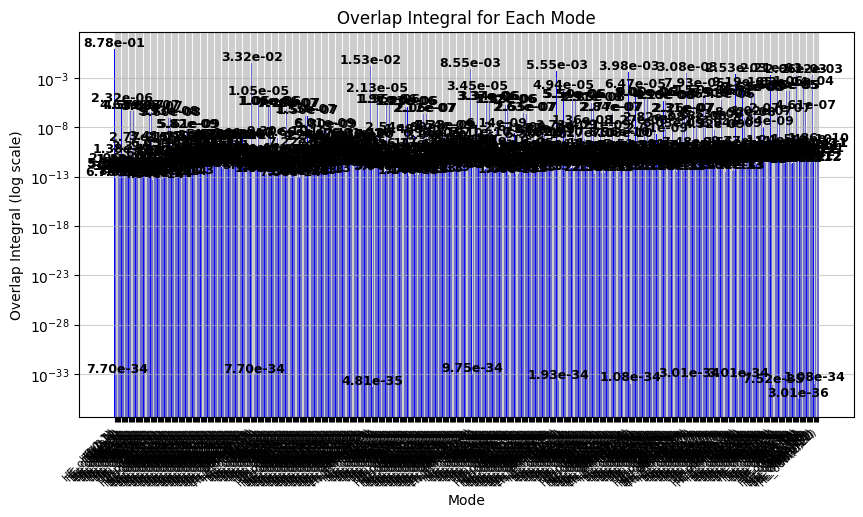

In [23]:
# Cell 9: Plot overlap integrals
plt.figure(figsize=(10, 5))
bars = plt.bar(mode_labels, [overlap_integrals[mode] for mode in modes], log=True, color="blue")

for bar, mode in zip(bars, modes):
    plt.text(bar.get_x() + bar.get_width()/2, overlap_integrals[mode], f"{overlap_integrals[mode]:.2e}",
             ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

plt.xlabel("Mode")
plt.ylabel("Overlap Integral (log scale)")
plt.title("Overlap Integral for Each Mode")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.grid(True, which="both", alpha=0.6)
plt.show()

In [14]:
# Cell 10: Calculate speckle pattern
def calculate_speckle(wavelength, filtered_modes):
    cumulative_sum = None
    for mode in filtered_modes:
        for i, fiber in enumerate(factory):
            field = fiber.field(mode, wavelength, 25e-6, num_points).eprop2(0, 0)
            cumulative_sum = field if cumulative_sum is None else cumulative_sum + field
    return cumulative_sum

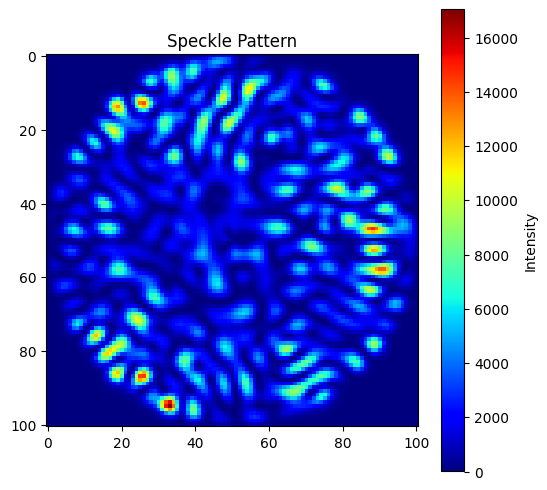

In [24]:
# Cell 11: Display speckle pattern
wavelength1 = 1.55e-6
speckle_pattern = calculate_speckle(wavelength1, filtered_modes)

plt.figure(figsize=(6, 6))
plt.imshow(np.abs(speckle_pattern) ** 2, cmap='jet', interpolation='none')
plt.title('Speckle Pattern')
plt.colorbar(label="Intensity")
plt.show()